# Classical AE with PCA on MNIST

For comparision I train a classical AE on MNIST on the PCA reduced data

### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae


import warnings
warnings.filterwarnings('ignore')

2022-06-29 08:51:55.839573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 08:51:55.839599: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-29 08:51:57.393859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-29 08:51:57.393879: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-29 08:51:57.393898: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-06-29 08:51:57.394581: I tensorflow/core/platform/cpu_fe

## Data 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

x_train:  (60000, 28, 28)
x_test:  (10000, 28, 28)
y_train:  (60000,)
y_test:  (10000,)


In [4]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


### Dimensionality reduction



In [5]:
DOWNSCALE = 2
DATA_DIMENSION = DOWNSCALE*DOWNSCALE
LATENT_BITS = 2

x_train, x_test = dp.PCA_reduce(x_train, DATA_DIMENSION, val_data=x_test)
print(np.max(x_train))
print(np.min(x_train))
print(x_train.shape)
print(x_test.shape)

1.0
0.0
(12049, 4)
(1968, 4)


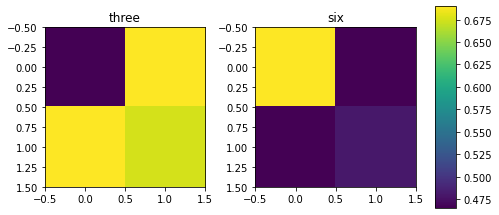

In [6]:
fig, axs = plt.subplots(1,2)
img0 = axs[0].imshow(np.average(x_train[y_train==True],0).reshape(DOWNSCALE,DOWNSCALE))
axs[0].title.set_text('three')

img1 = axs[1].imshow(np.average(x_train[y_train==False],0).reshape(DOWNSCALE,DOWNSCALE))
axs[1].title.set_text('six')

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(img1, orientation='vertical', cax=cbar_ax)

fig.tight_layout()

After the PCA it looks like Photons and Electrons should still seperate quite well.

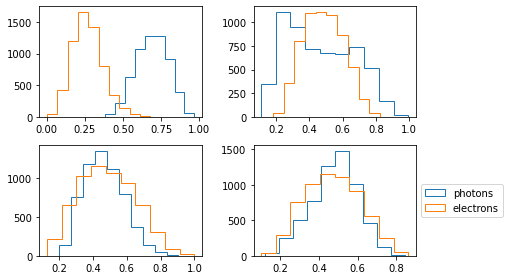

In [7]:
fig, axs = plt.subplots(DOWNSCALE,DOWNSCALE)
for i in range(0,DATA_DIMENSION):
    axs[i//DOWNSCALE,i%DOWNSCALE].hist(x_train[y_train==0][:,i], label="photons", histtype='step')
    axs[i//DOWNSCALE,i%DOWNSCALE].hist(x_train[y_train==1][:,i], label="electrons", histtype='step')
fig.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

I want only want to train the AE on Photons and later try to separate them from the electrons without training on electron data.
Therefore I only include Photons in x_train.


In [8]:
x_train_threes = x_train[y_train==True]
x_train = x_train[y_train==False]

x_test_threes = x_test[y_test==True]
x_test = x_test[y_test==False]

In [9]:
num_data, x_dim = x_train.shape

# CAE model

In [10]:
latent_dim = 2
ae = cae.Autoencoder(x_dim, latent_dim)

In [11]:
ae.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.05))

In [12]:
ae.build(x_train.shape)
ae.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2)                 10        
                                                                 
 sequential_1 (Sequential)   (5918, 4)                 12        
                                                                 
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
hist = ae.fit(x_train, x_train,
                epochs=40,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[es])

Epoch 1/40
185/185 [==============================] - 0s 985us/step - loss: 0.0184 - val_loss: 0.0100
Epoch 2/40
185/185 [==============================] - 0s 697us/step - loss: 0.0083 - val_loss: 0.0087
Epoch 3/40
185/185 [==============================] - 0s 706us/step - loss: 0.0083 - val_loss: 0.0088
Epoch 4/40
185/185 [==============================] - 0s 651us/step - loss: 0.0083 - val_loss: 0.0088
Epoch 5/40
185/185 [==============================] - 0s 676us/step - loss: 0.0083 - val_loss: 0.0088
Epoch 6/40
185/185 [==============================] - 0s 673us/step - loss: 0.0083 - val_loss: 0.0088
Epoch 7/40
185/185 [==============================] - 0s 713us/step - loss: 0.0083 - val_loss: 0.0088
Epoch 8/40
185/185 [==============================] - 0s 642us/step - loss: 0.0083 - val_loss: 0.0087
Epoch 9/40
185/185 [==============================] - 0s 660us/step - loss: 0.0083 - val_loss: 0.0088


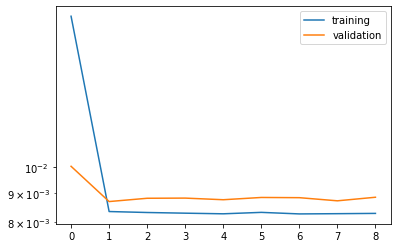

In [14]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

## Evaluation

In [15]:
def mae(x):
    pred = ae.predict(x)
    return np.mean(np.abs(x - pred)**2,axis=1)

def recon_acc(x):
    return 1 - mae(x)

In [16]:
sixes = recon_acc(x_test)
threes = recon_acc(x_test_threes)

0.993733302051298
0.9409245327773734


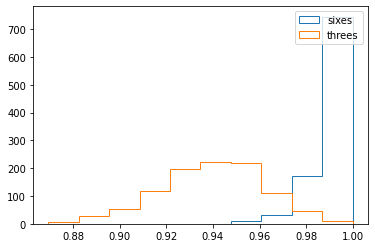

In [17]:
print(np.median(sixes))
bins = np.histogram(np.hstack((sixes, threes)), bins=10)[1]
plt.hist(sixes, histtype='step', label="sixes",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
print(np.median(threes))
plt.hist(threes, histtype='step', label="threes",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.legend()

0.9471544715447154


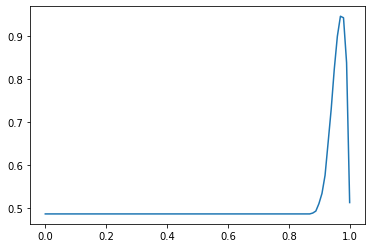

In [18]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(sixes > T)
    # threes that are predicted three
    num_three_right = np.sum(threes < T)
    acc = (num_six_right + num_three_right)/(len(sixes) + len(threes))
    return acc

Ts = np.linspace(0,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
print(max(accs))
plt.plot(Ts, accs)  